In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from scipy.signal import savgol_filter
import random
from joblib import load
import helper_scripts
import unsupervised_scripts

## Sample Directory (different for everyone)
data_dir = (input('Enter the path to your .tif hyperstacks: ').strip() or os.getcwd())
save_dir = (input('Enter the path to your save directory: ').strip() or os.getcwd())

## Load Image
from tkinter import*
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
sample = filedialog.askopenfilename(initialdir=data_dir, multiple=True)
image = io.imread(sample[0])

## Vectorize Image
image_vec = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
image_vec = image_vec.T

## Remove NaNs and inf
image[np.isinf(image)] = 0
image[np.isnan(image)] = 0

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2750)): ').strip() or '2750')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(image_vec.shape[1]) 
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')

### Semi-Supervised Learning

## Load artificial dataset
artificial_data = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
[mol_norm, mol_names] = artificial_data.molecule_dataset(molecule_df)

X_data = np.load('artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_standard = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_standard = preprocessing.spectral_standardization(np.flip(image_vec,axis=1))
image_max = np.max(np.percentile(image_standard,99,axis=0))
image_norm = helper_scripts.normalize_manual(image_standard, max_val=image_max, min_val=np.median(image_standard[:,:ch_start]))
image_norm = image_norm-np.median(image_norm[:,:ch_start],axis=1)[0]
X_norm = helper_scripts.normalize(X_standard, max=np.max(image_norm))
X_norm = X_norm-np.median(X_norm[:,:ch_start],axis=1)[0]


Text(0, 0.5, 'Normalized Intensity (A.U.)')

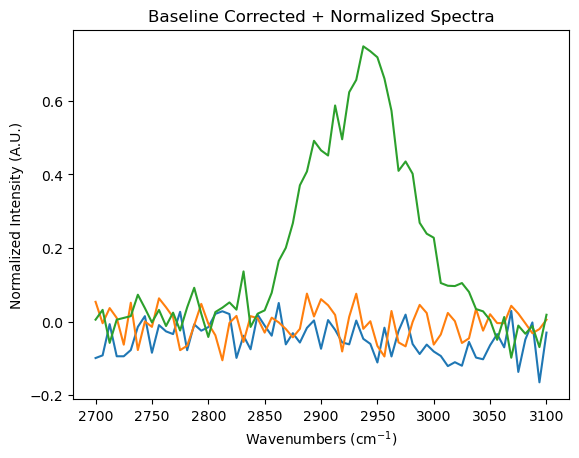

In [3]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T)
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

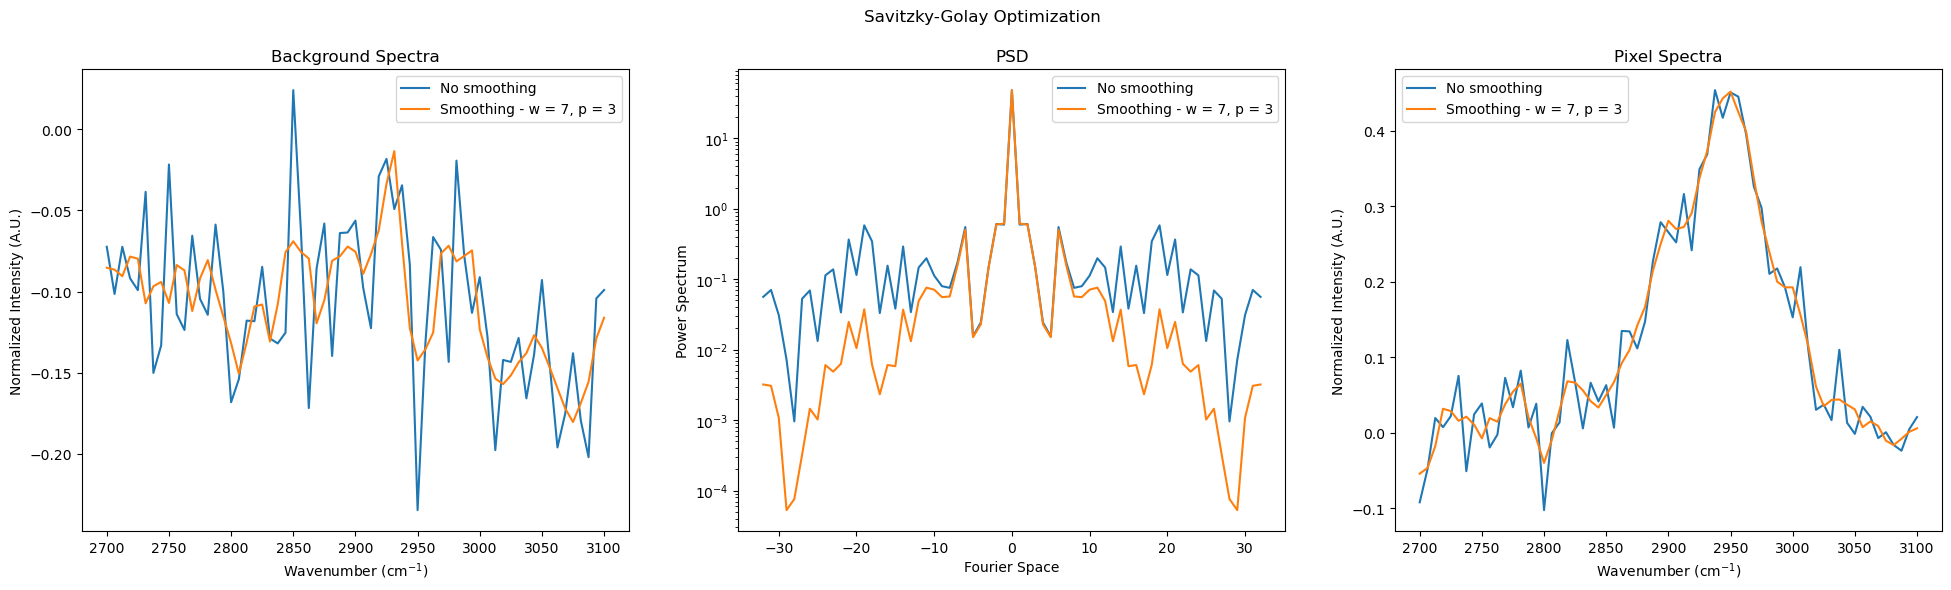

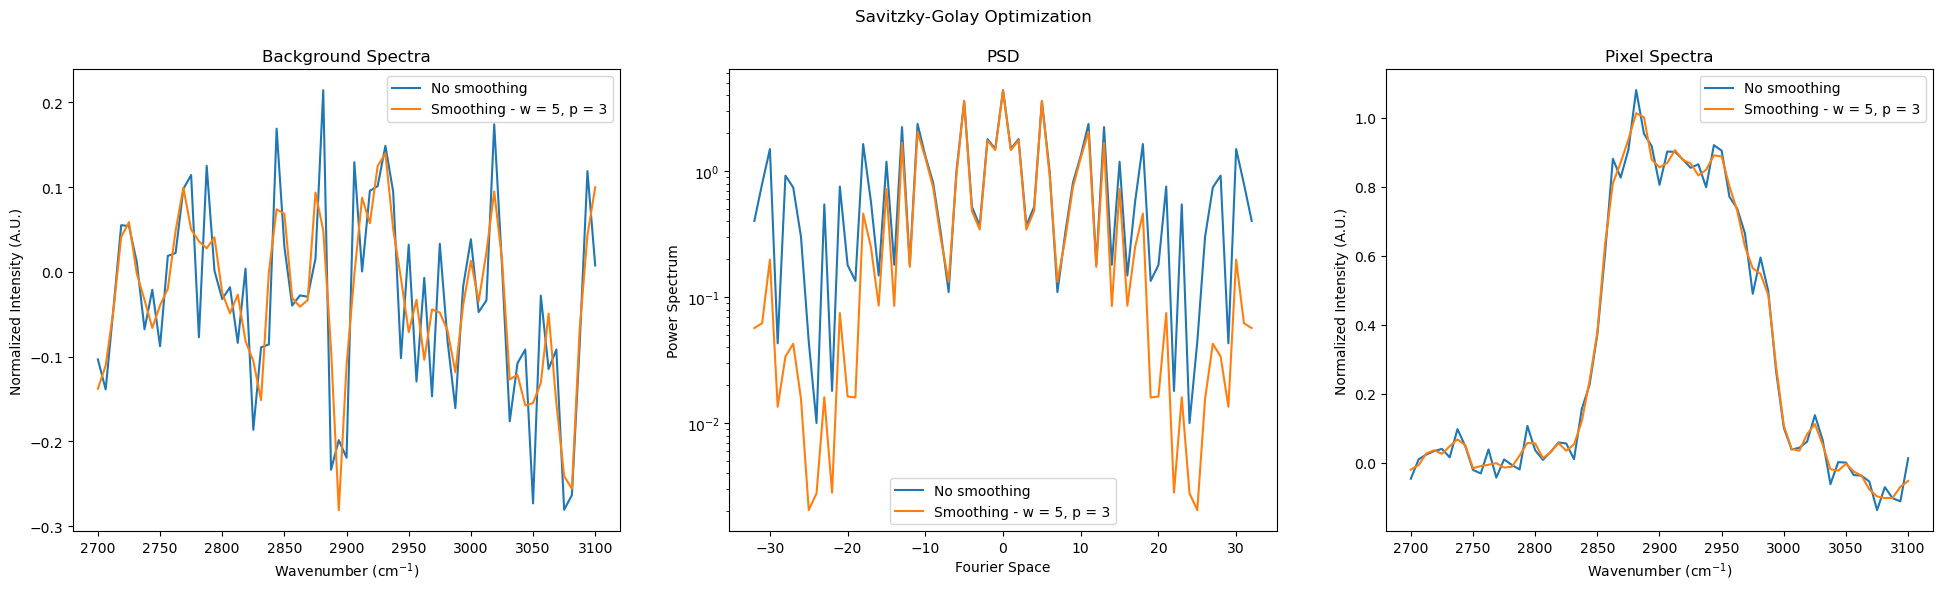

In [ ]:
## Optimize Smoothing of HSI and artificial spectra

w = int(input('Enter window size for Savitzky-Golay smoothing (Default=7): ').strip() or '7')
p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
preprocessing.sav_gol_optimization(image_norm, w, p)
preprocessing.sav_gol_optimization(X_norm, w-2, p)
x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
X = savgol_filter(X_norm,w-2,p, axis=1, mode='mirror')

In [ ]:
## Random Forest Classification

rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
rfc = load('rfc'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.joblib')
rfc.score(rf_classifier.X_train, rf_classifier.y_train)

0.986625641025641

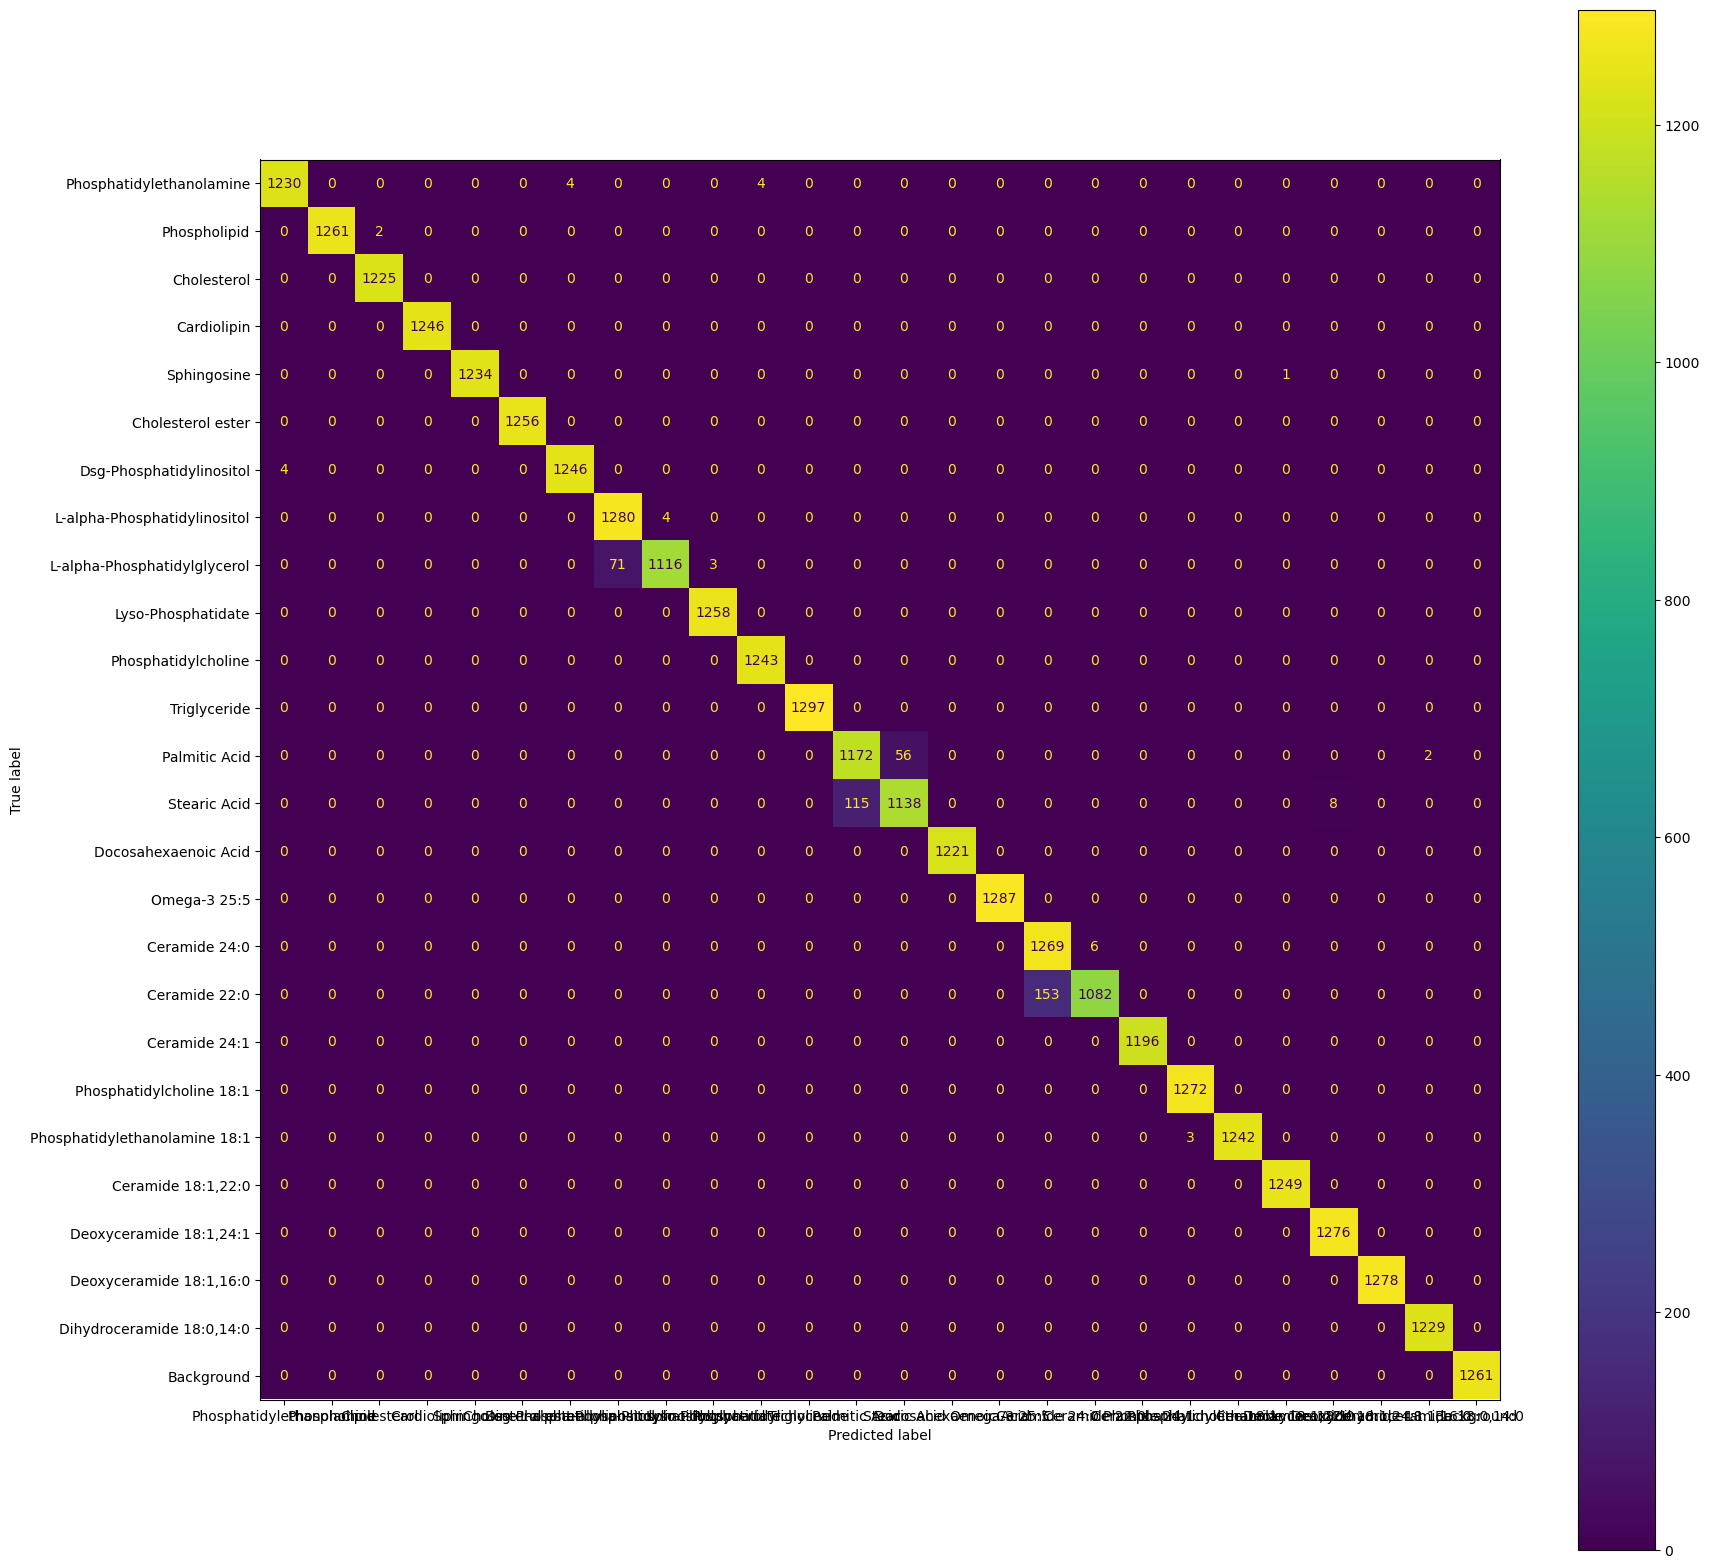

In [6]:
rf_classifier.confusion_matrix(mol_names, rfc)

In [7]:
outputs = unsupervised_scripts.semi_supervised_outputs(x, mol_names, rfc)

Save spectral graphs?


 80%|████████  | 20/25 [00:11<00:02,  2.10it/s]d:\Shi_Lab\Spectral_Clustering\unsupervised_scripts.py:355: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))
100%|██████████| 25/25 [00:13<00:00,  1.82it/s]


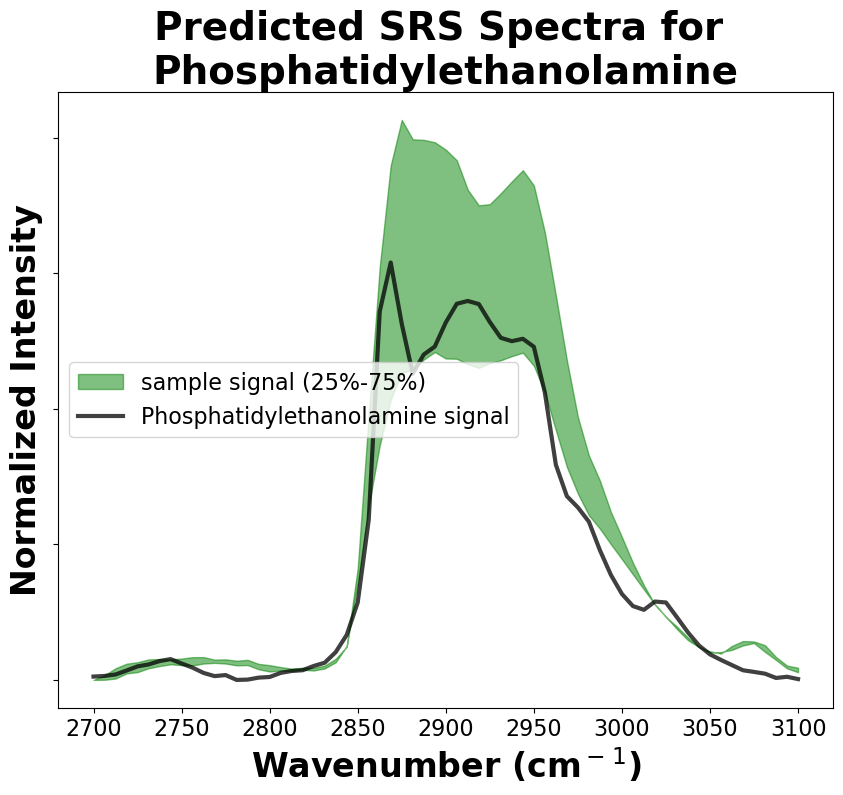

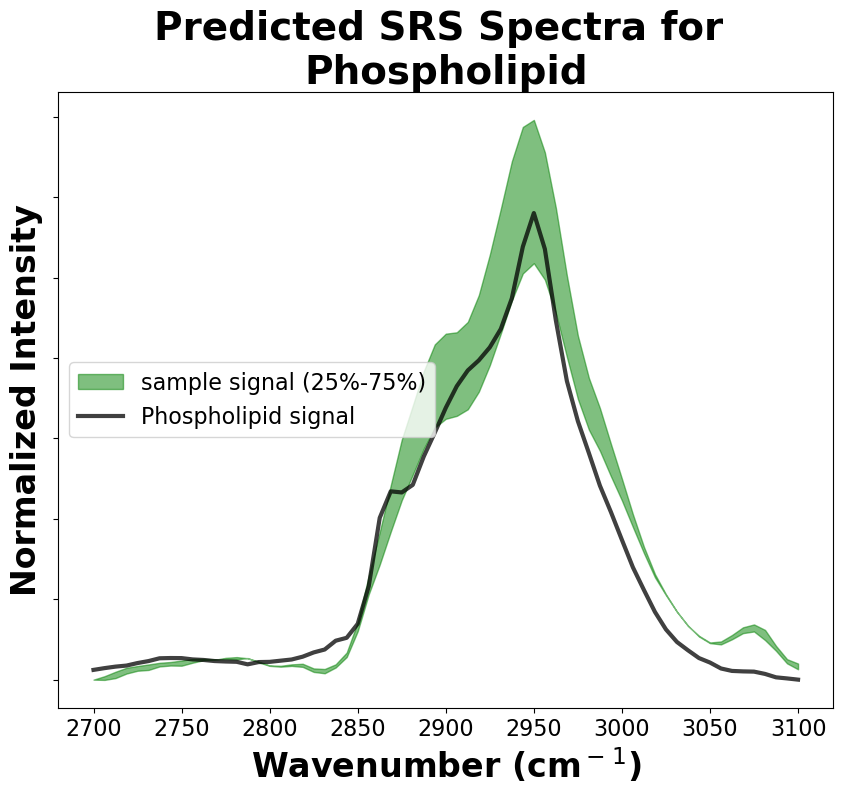

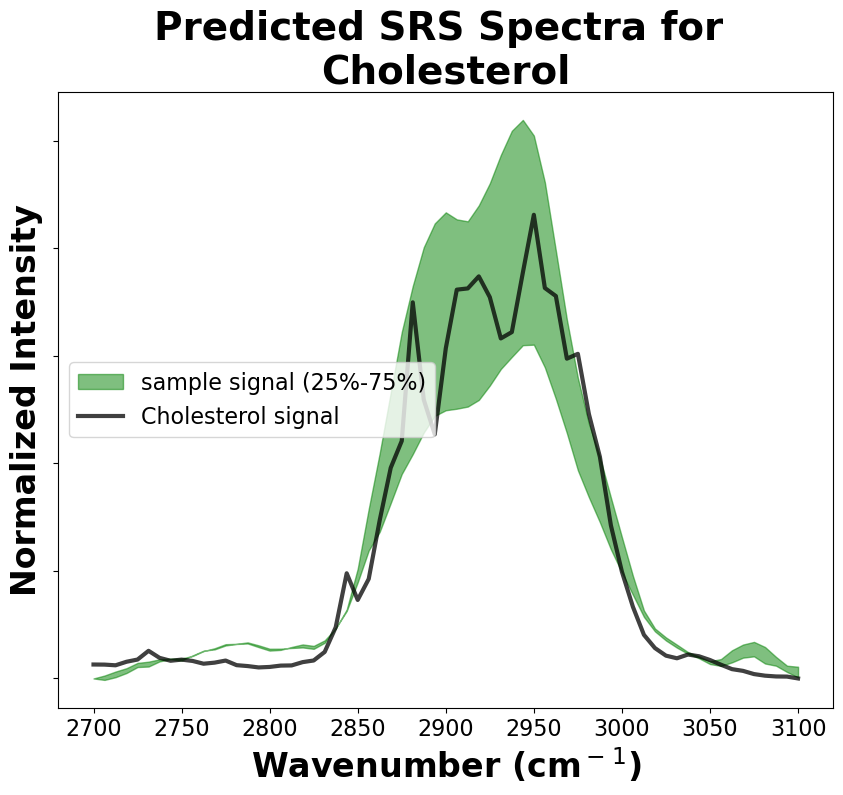

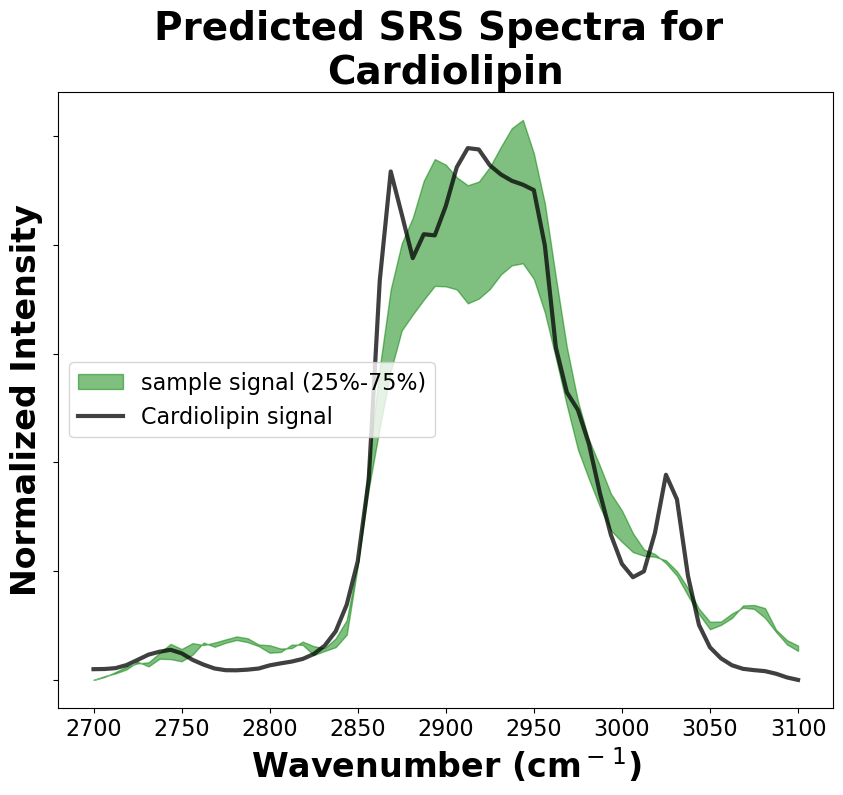

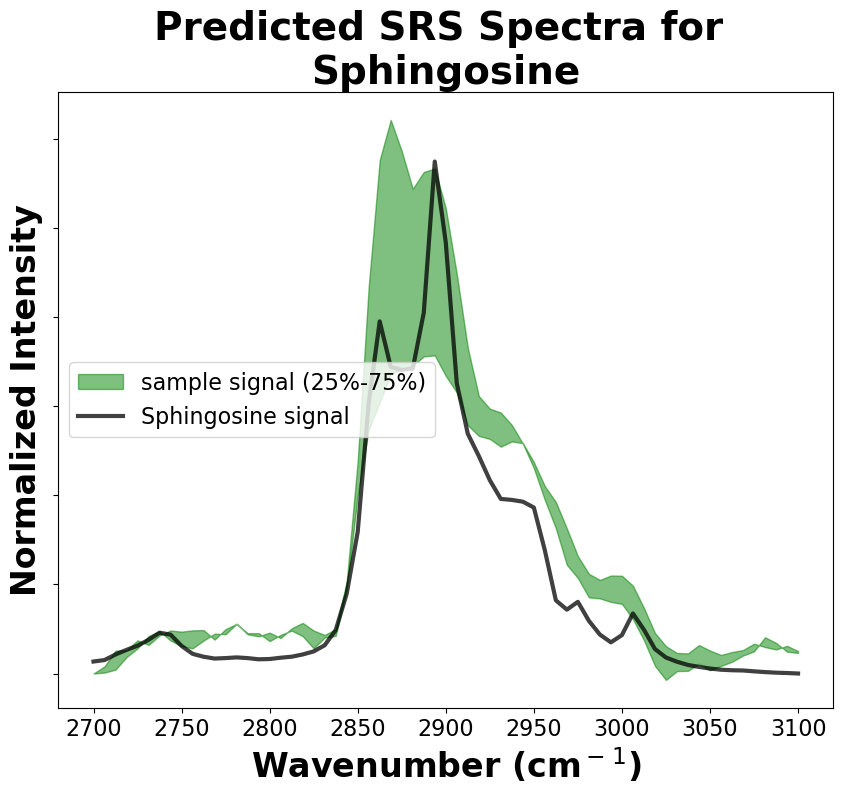

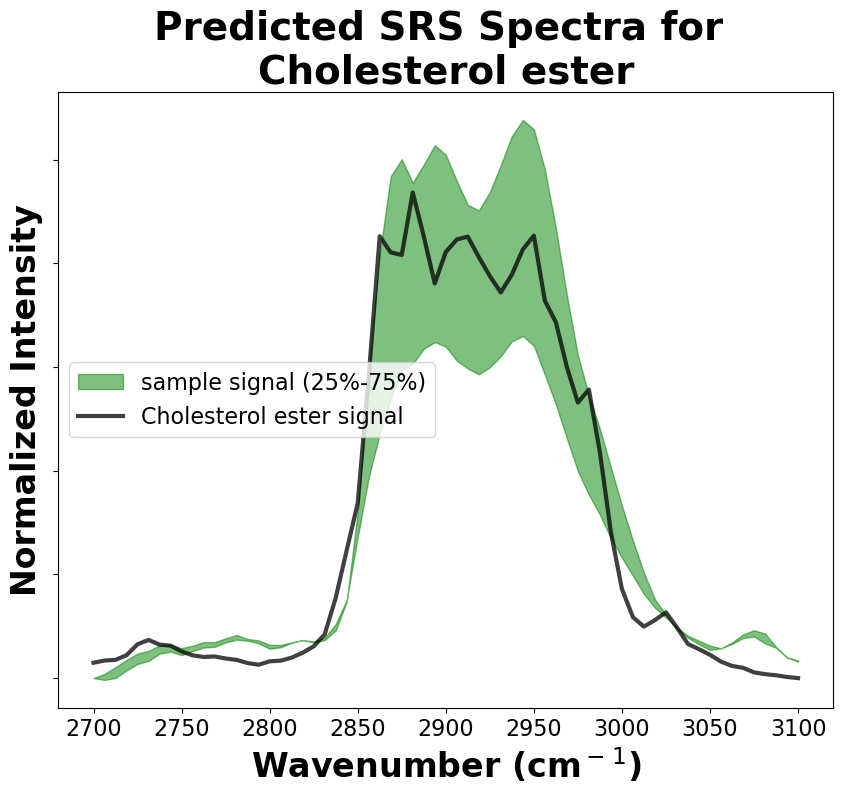

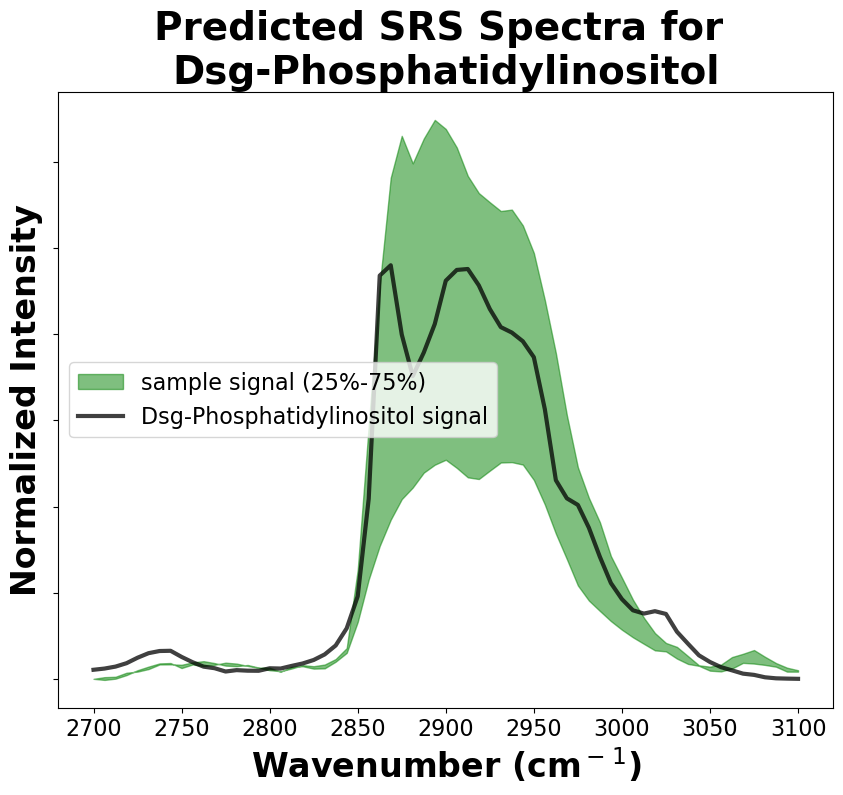

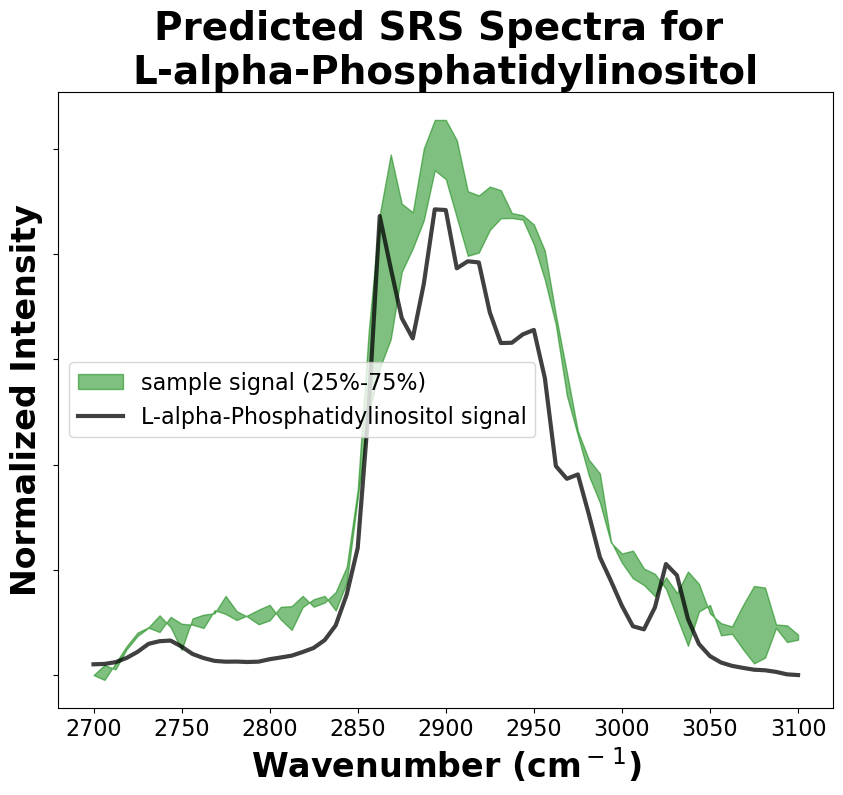

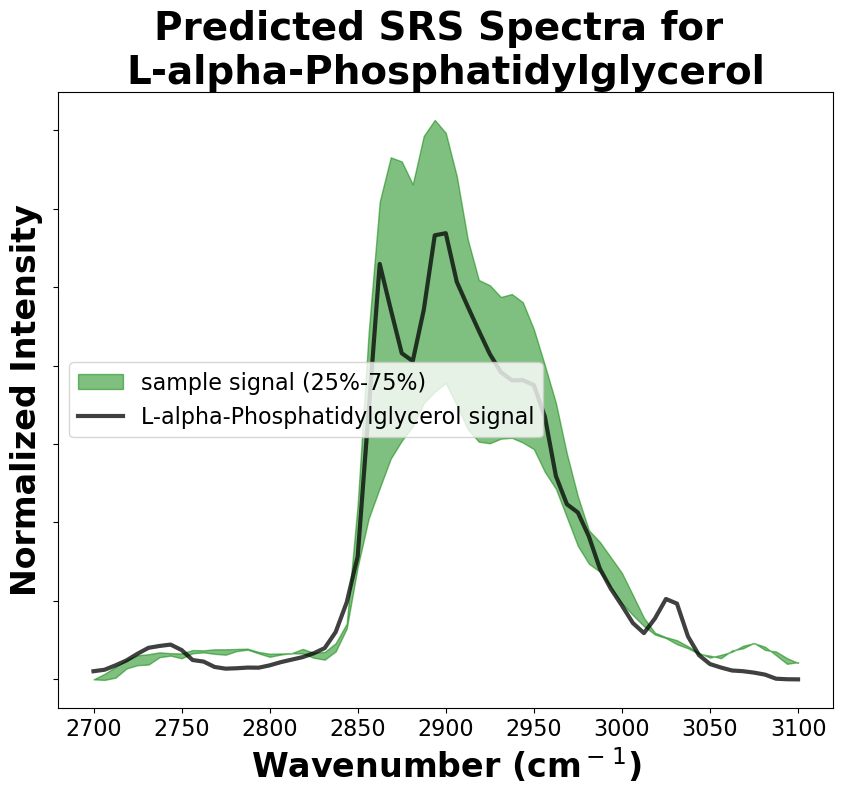

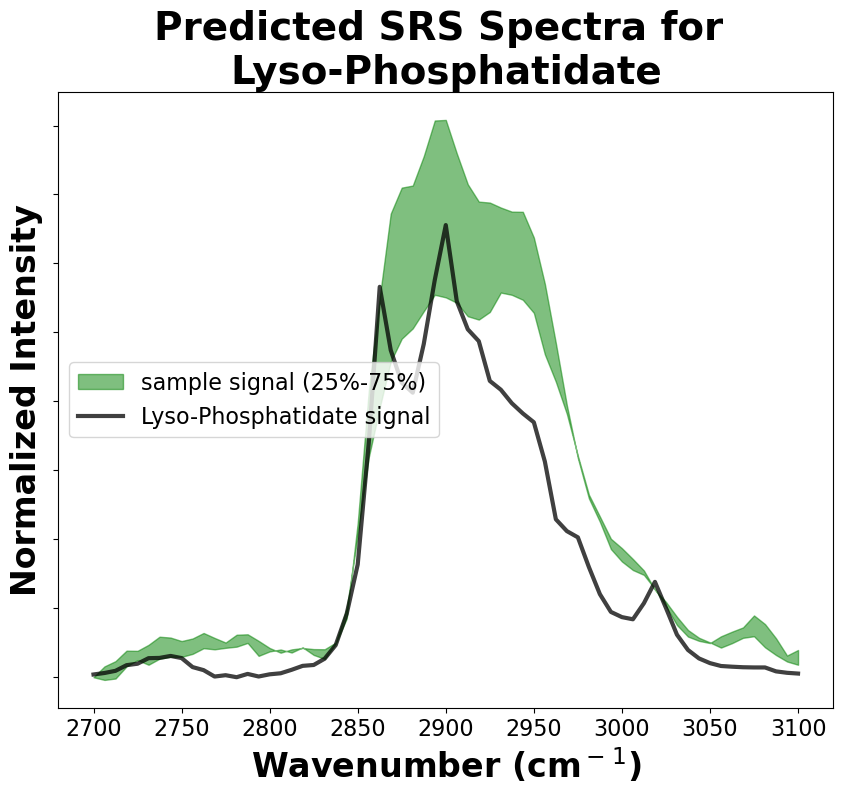

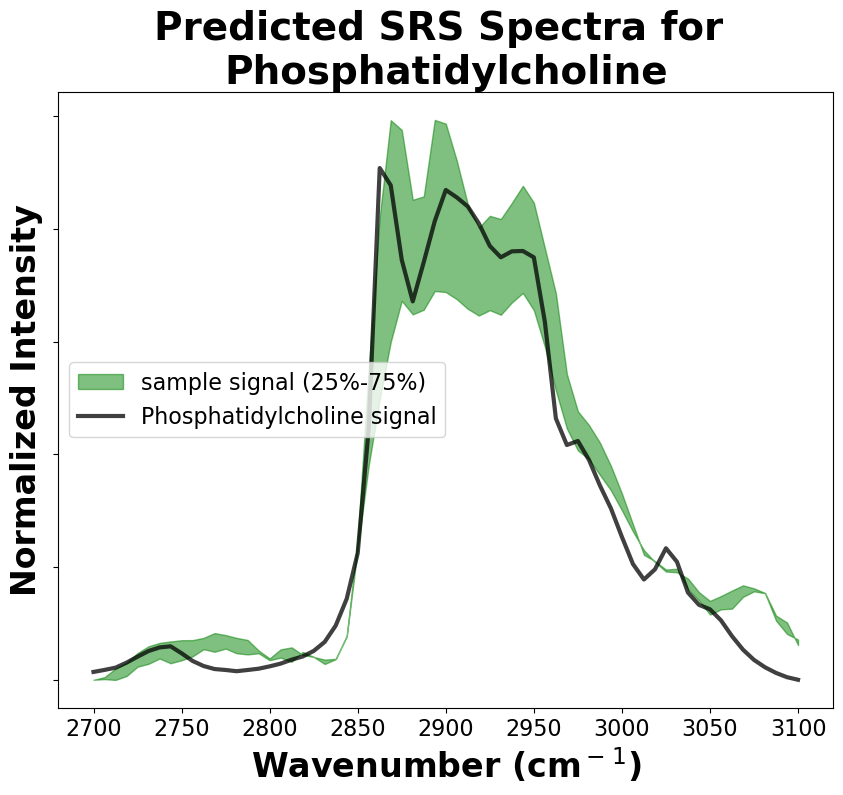

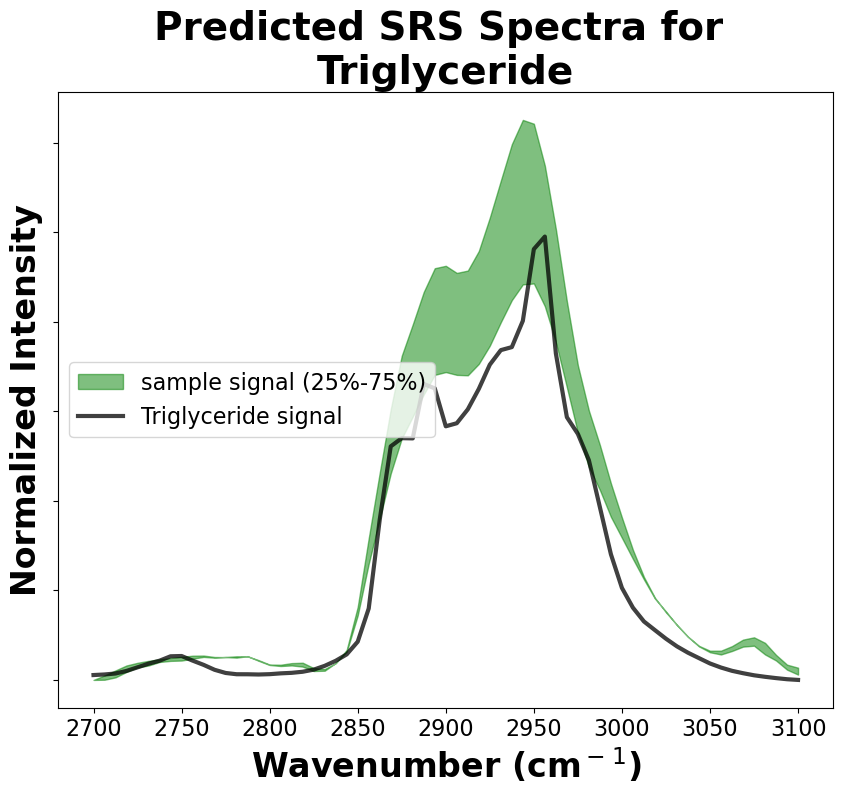

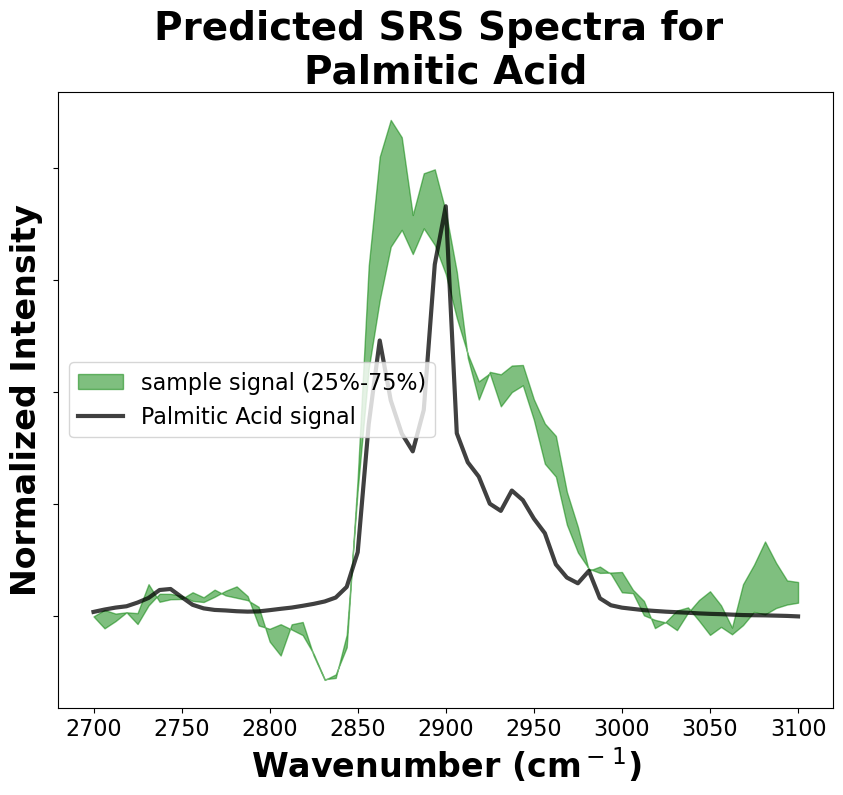

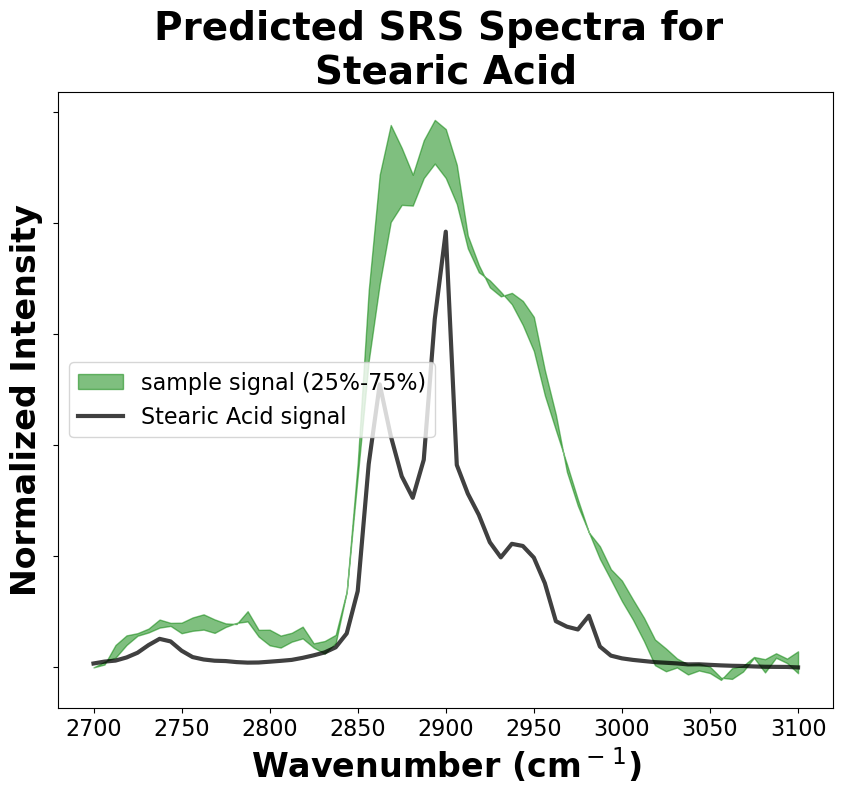

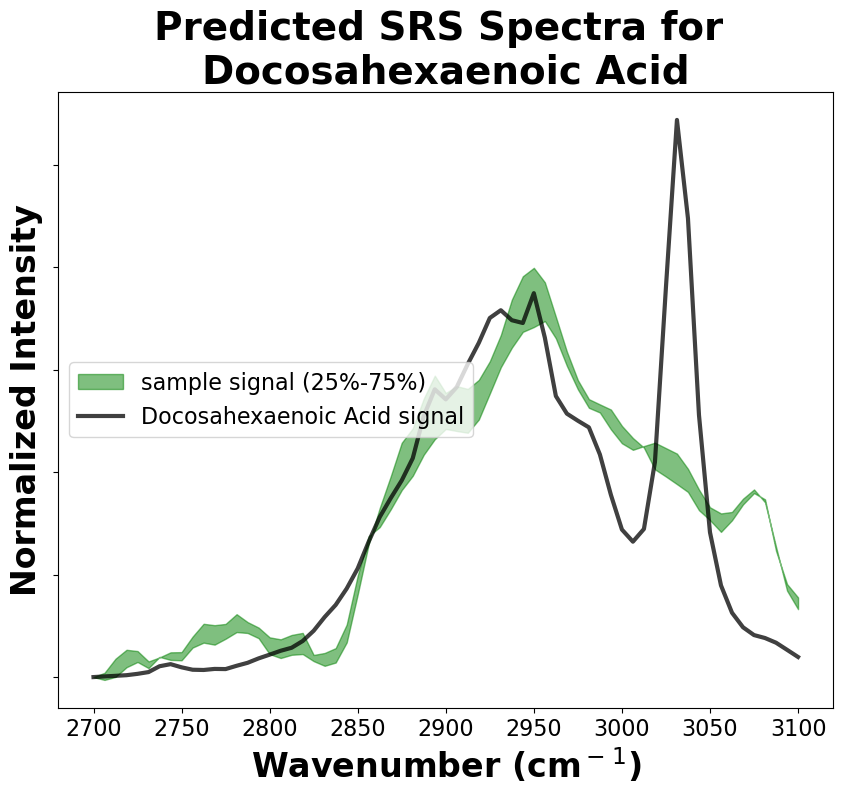

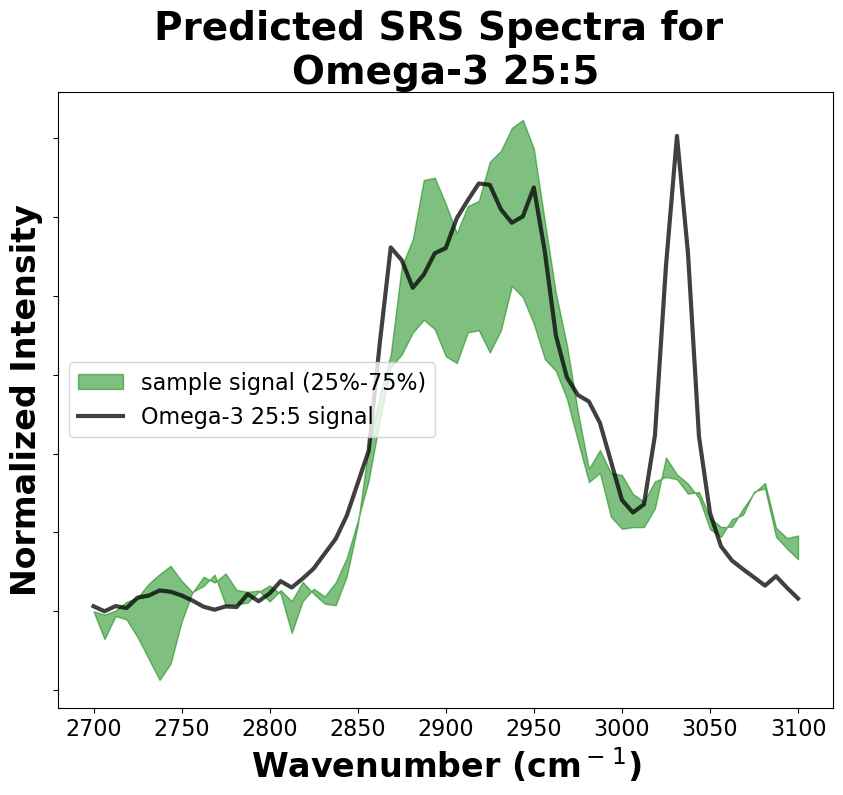

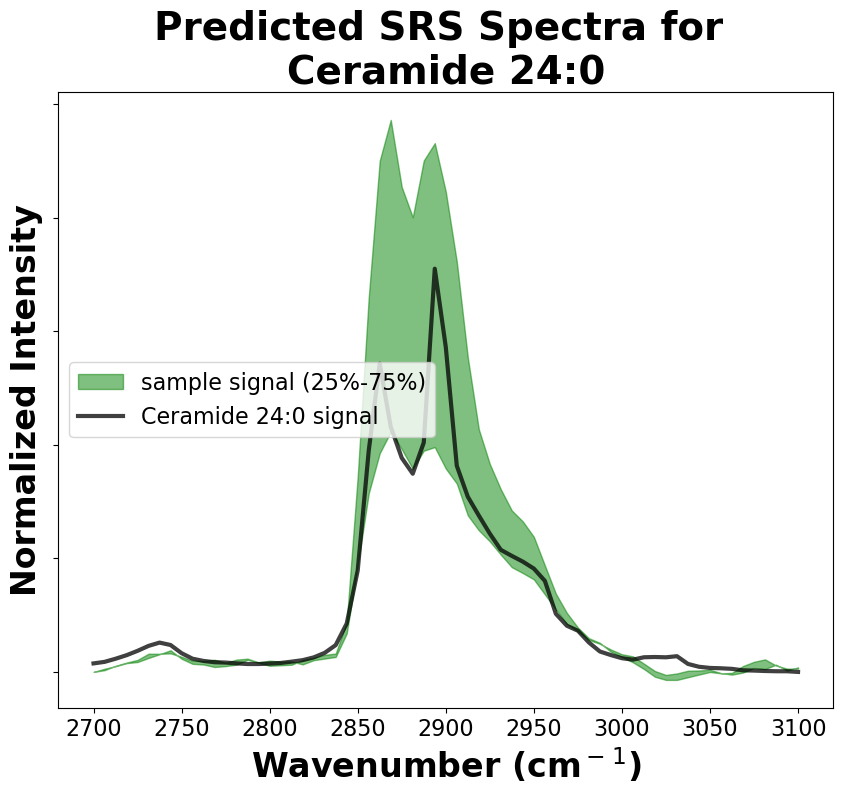

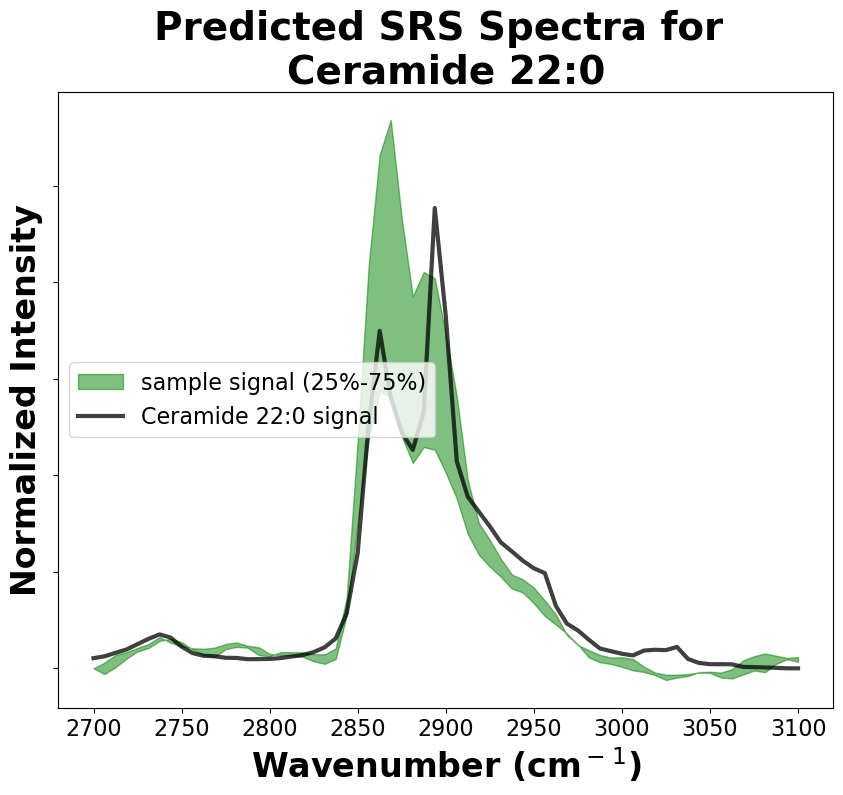

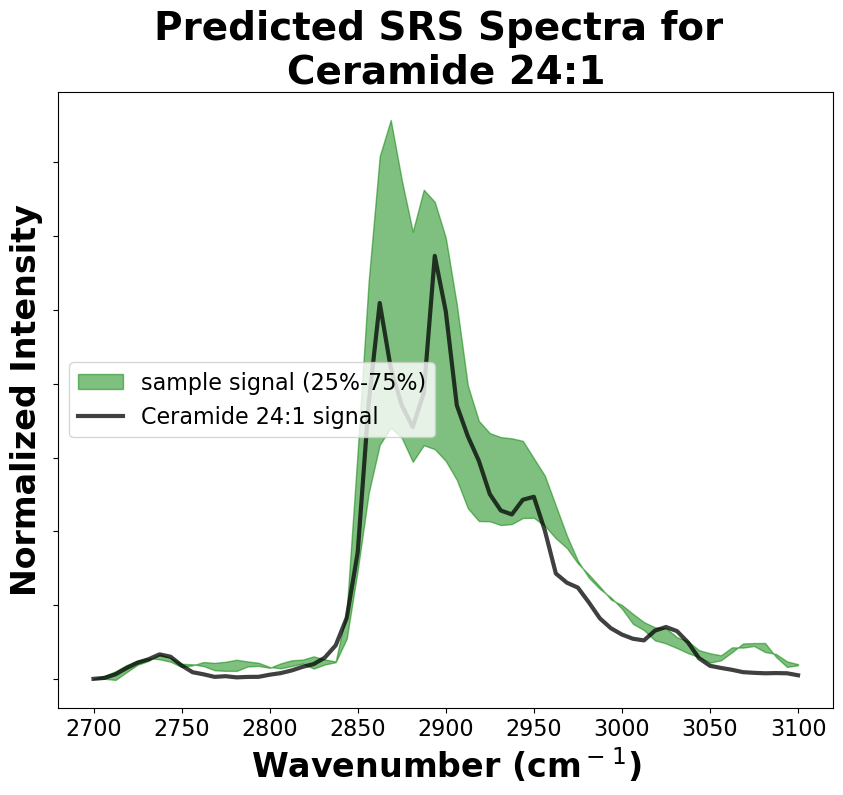

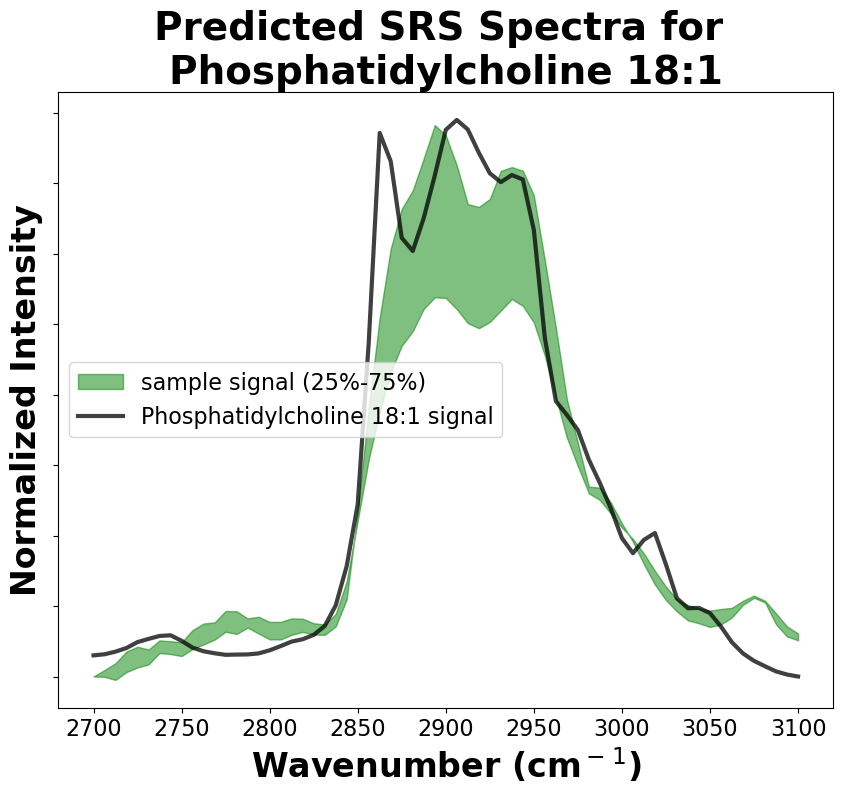

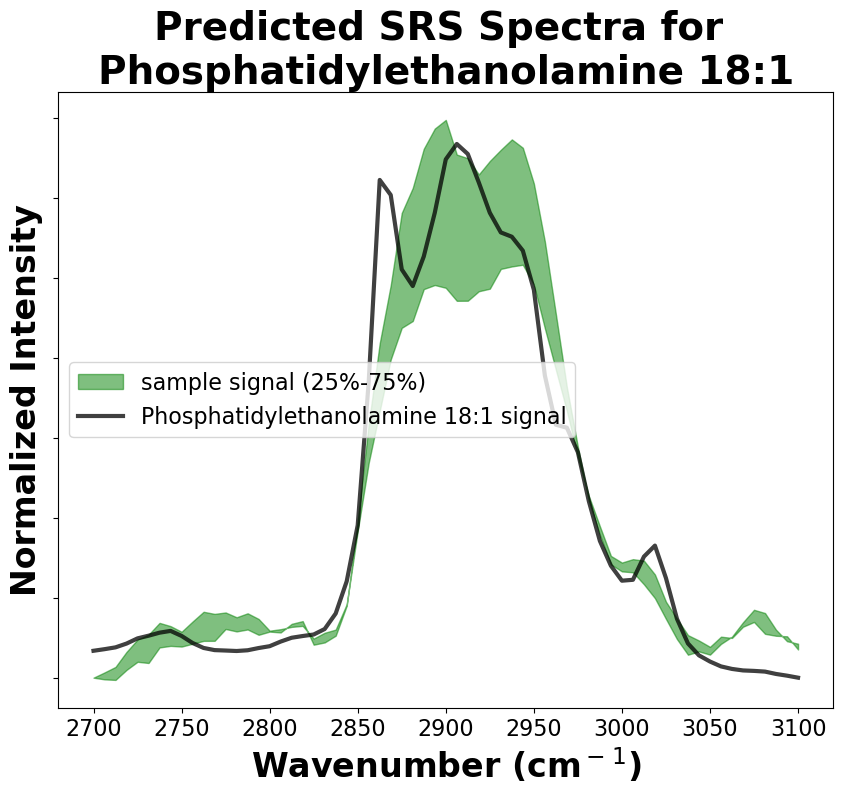

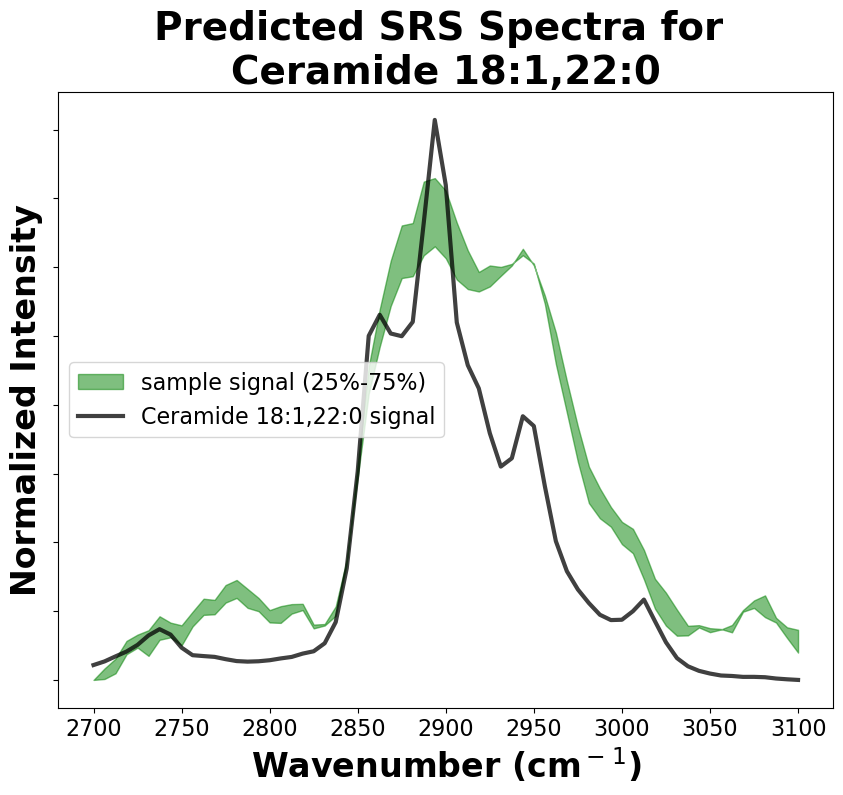

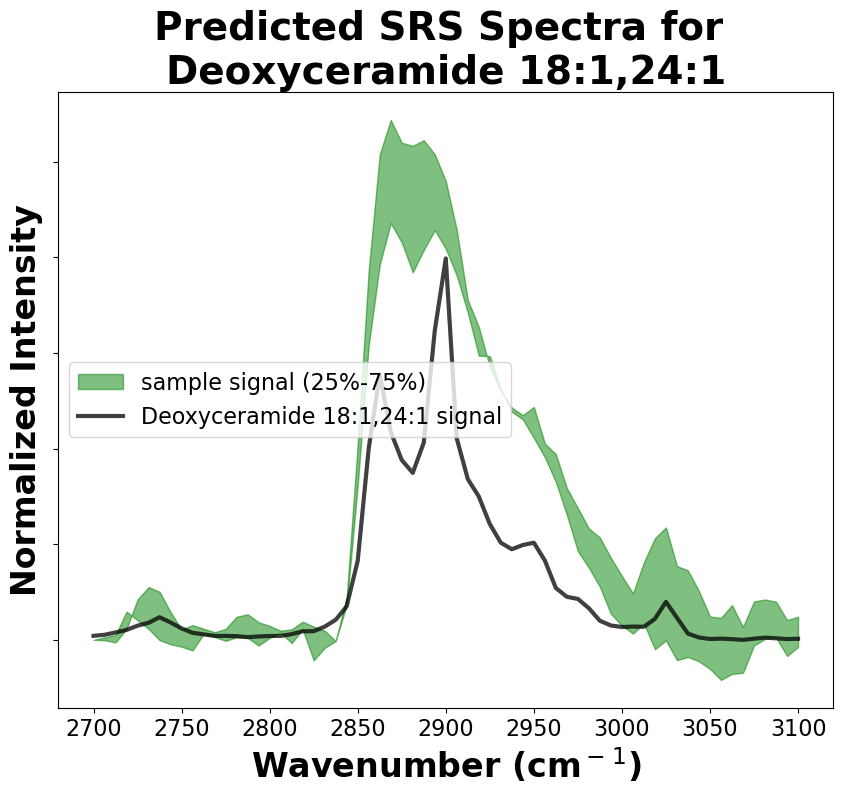

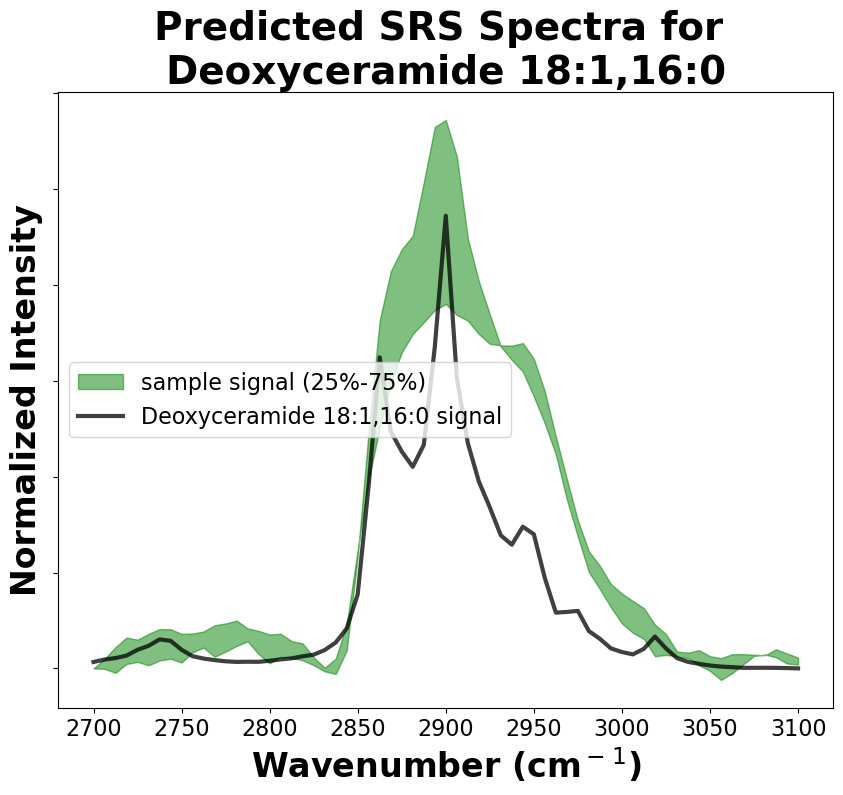

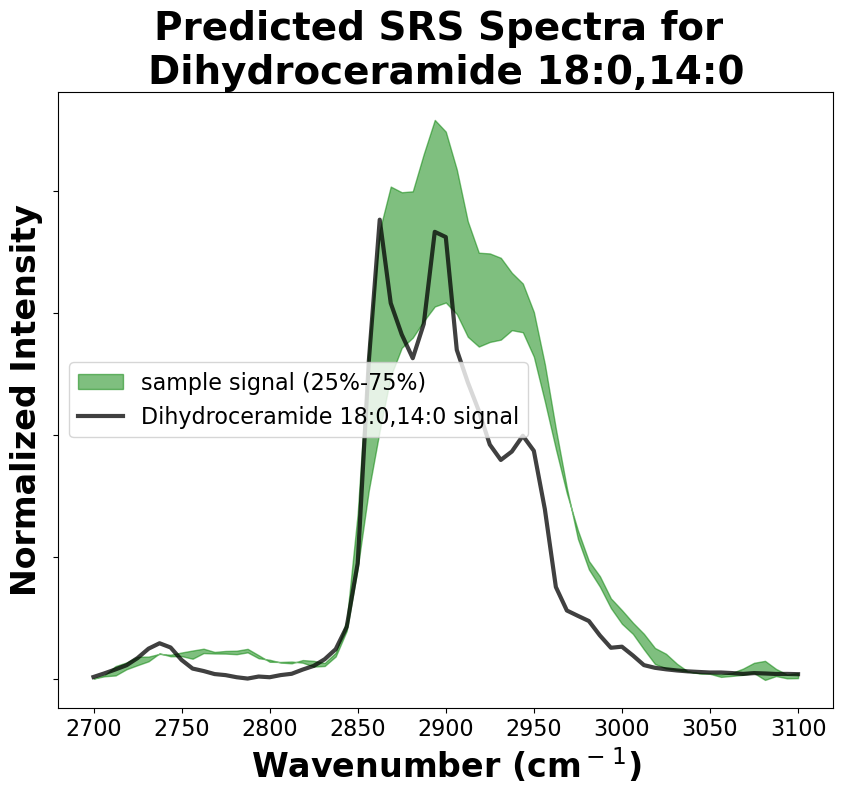

In [8]:
print('Save spectral graphs?')
save_input = helper_scripts.save_input()
outputs.spectral_graphs(mol_norm, wavenumbers, save_input, save_dir)

In [9]:
print('Save similarity metric .csv?')
save_input = helper_scripts.save_input()
outputs.similarity_metrics(mol_norm, save_input, save_dir)

Save similarity metric .csv?


100%|██████████| 456/456 [00:00<00:00, 774.22it/s]


The MSE for Phosphatidylethanolamine is: 0.061625931244463306
The Cosine Similarity for Phosphatidylethanolamine is: 0.9811771121011648
The Cross-Correlation for Phosphatidylethanolamine is: 0.9811771121011651


100%|██████████| 183379/183379 [04:07<00:00, 739.66it/s]


The MSE for Phospholipid is: 0.043106507390796016
The Cosine Similarity for Phospholipid is: 0.9881428706743579
The Cross-Correlation for Phospholipid is: 0.9911225079750673


100%|██████████| 1502/1502 [00:01<00:00, 802.45it/s]


The MSE for Cholesterol is: 0.008827912259230918
The Cosine Similarity for Cholesterol is: 0.9412773153550777
The Cross-Correlation for Cholesterol is: 0.9412773153550776


100%|██████████| 265/265 [00:00<00:00, 817.24it/s]


The MSE for Cardiolipin is: 0.004283327754875595
The Cosine Similarity for Cardiolipin is: 0.9774060042597035
The Cross-Correlation for Cardiolipin is: 0.9774060042597035


100%|██████████| 247/247 [00:00<00:00, 887.41it/s]


The MSE for Sphingosine is: 0.0021147040305493593
The Cosine Similarity for Sphingosine is: 0.8443512575137223
The Cross-Correlation for Sphingosine is: 0.8630426696854828


100%|██████████| 1502/1502 [00:01<00:00, 817.13it/s]


The MSE for Cholesterol ester is: 0.007229411657745542
The Cosine Similarity for Cholesterol ester is: 0.9679685900128303
The Cross-Correlation for Cholesterol ester is: 0.9707419765640358


100%|██████████| 104/104 [00:00<00:00, 694.94it/s]


The MSE for Dsg-Phosphatidylinositol is: 0.011014936016104034
The Cosine Similarity for Dsg-Phosphatidylinositol is: 0.9788685202689331
The Cross-Correlation for Dsg-Phosphatidylinositol is: 0.9800408763835774


100%|██████████| 9/9 [00:00<00:00, 602.10it/s]


The MSE for L-alpha-Phosphatidylinositol is: 0.0022343836958311505
The Cosine Similarity for L-alpha-Phosphatidylinositol is: 0.9801346500708815
The Cross-Correlation for L-alpha-Phosphatidylinositol is: 0.9801346500708815


100%|██████████| 301/301 [00:00<00:00, 908.18it/s]


The MSE for L-alpha-Phosphatidylglycerol is: 0.008827513711036518
The Cosine Similarity for L-alpha-Phosphatidylglycerol is: 0.9581329599029649
The Cross-Correlation for L-alpha-Phosphatidylglycerol is: 0.9687586739265014


100%|██████████| 317/317 [00:00<00:00, 870.19it/s]


The MSE for Lyso-Phosphatidate is: 0.0076448488574258604
The Cosine Similarity for Lyso-Phosphatidate is: 0.9402682809755567
The Cross-Correlation for Lyso-Phosphatidate is: 0.9424476275349397


100%|██████████| 121/121 [00:00<00:00, 860.80it/s]


The MSE for Phosphatidylcholine is: 0.011403342697420184
The Cosine Similarity for Phosphatidylcholine is: 0.9852079443250285
The Cross-Correlation for Phosphatidylcholine is: 0.9852079443250282


100%|██████████| 20246/20246 [00:24<00:00, 833.52it/s]


The MSE for Triglyceride is: 0.026341094148279953
The Cosine Similarity for Triglyceride is: 0.9881400453128907
The Cross-Correlation for Triglyceride is: 0.988140045312891


100%|██████████| 49/49 [00:00<00:00, 964.01it/s]


The MSE for Palmitic Acid is: 0.0010686954935574052
The Cosine Similarity for Palmitic Acid is: 0.8117796920429148
The Cross-Correlation for Palmitic Acid is: 0.8122446405301345


100%|██████████| 372/372 [00:00<00:00, 886.89it/s]


The MSE for Stearic Acid is: 0.003852866874519756
The Cosine Similarity for Stearic Acid is: 0.8202591590960275
The Cross-Correlation for Stearic Acid is: 0.8202591590960276


100%|██████████| 524/524 [00:00<00:00, 839.45it/s]


The MSE for Docosahexaenoic Acid is: 0.002597672474011567
The Cosine Similarity for Docosahexaenoic Acid is: 0.8870754804632321
The Cross-Correlation for Docosahexaenoic Acid is: 0.906509387762438


100%|██████████| 17/17 [00:00<00:00, 695.98it/s]


The MSE for Omega-3 25:5 is: 0.0027783269221178003
The Cosine Similarity for Omega-3 25:5 is: 0.929695730741088
The Cross-Correlation for Omega-3 25:5 is: 0.9296957307410881


100%|██████████| 103/103 [00:00<00:00, 764.27it/s]


The MSE for Ceramide 24:0 is: 0.021517857580260702
The Cosine Similarity for Ceramide 24:0 is: 0.9665006454786684
The Cross-Correlation for Ceramide 24:0 is: 0.9665006454786687


100%|██████████| 406/406 [00:00<00:00, 831.56it/s]


The MSE for Ceramide 22:0 is: 0.007648282065808805
The Cosine Similarity for Ceramide 22:0 is: 0.7379946223234535
The Cross-Correlation for Ceramide 22:0 is: 0.7382502062008071


100%|██████████| 151/151 [00:00<00:00, 605.23it/s]


The MSE for Ceramide 24:1 is: 0.2653384262588082
The Cosine Similarity for Ceramide 24:1 is: 0.9874712170850839
The Cross-Correlation for Ceramide 24:1 is: 0.987471217085084


100%|██████████| 351/351 [00:00<00:00, 878.59it/s]


The MSE for Phosphatidylcholine 18:1 is: 0.005879530368399915
The Cosine Similarity for Phosphatidylcholine 18:1 is: 0.9117541243573843
The Cross-Correlation for Phosphatidylcholine 18:1 is: 0.9201642954336162


100%|██████████| 239/239 [00:00<00:00, 857.98it/s]


The MSE for Phosphatidylethanolamine 18:1 is: 0.0020610419237184867
The Cosine Similarity for Phosphatidylethanolamine 18:1 is: 0.9559844760267873
The Cross-Correlation for Phosphatidylethanolamine 18:1 is: 0.9676133309652569


100%|██████████| 1173/1173 [00:01<00:00, 848.47it/s]


The MSE for Ceramide 18:1,22:0 is: 0.001286339734312738
The Cosine Similarity for Ceramide 18:1,22:0 is: 0.8427677933051176
The Cross-Correlation for Ceramide 18:1,22:0 is: 0.8459274214404493


100%|██████████| 56/56 [00:00<00:00, 874.94it/s]


The MSE for Deoxyceramide 18:1,24:1 is: 0.006514785044509058
The Cosine Similarity for Deoxyceramide 18:1,24:1 is: 0.7750282001908769
The Cross-Correlation for Deoxyceramide 18:1,24:1 is: 0.7750282001908769


100%|██████████| 347/347 [00:00<00:00, 828.44it/s]


The MSE for Deoxyceramide 18:1,16:0 is: 0.0014448838545315975
The Cosine Similarity for Deoxyceramide 18:1,16:0 is: 0.8288702764220786
The Cross-Correlation for Deoxyceramide 18:1,16:0 is: 0.8762924210810125


100%|██████████| 554/554 [00:00<00:00, 866.46it/s]


The MSE for Dihydroceramide 18:0,14:0 is: 0.00730435363313525
The Cosine Similarity for Dihydroceramide 18:0,14:0 is: 0.9592473957267782
The Cross-Correlation for Dihydroceramide 18:0,14:0 is: 0.9743402491827179


PermissionError: [Errno 13] Permission denied: 'D:/Shi_Lab/sample_data/Mouse Organ Sweeps/output/Metrics.csv'

In [40]:
print('Save probability images?')
save_input = helper_scripts.save_input()
outputs.probability_images(image, save_input, save_dir)